<a href="https://colab.research.google.com/github/aimbsg/EVA4_S14/blob/master/EVA4_S14_Dense_depth_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
drive.flush_and_unmount()

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%cd '/content/gdrive/My Drive/EVA4_S14_S15/'

/content/gdrive/My Drive/EVA4_S14_S15


In [0]:
!git clone https://github.com/ialhashim/DenseDepth.git

Cloning into 'DenseDepth'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 235 (delta 0), reused 1 (delta 0), pack-reused 231
Receiving objects: 100% (235/235), 11.80 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5

--2020-05-09 03:01:48--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.108.91
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.108.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DenseDepth/nyu.h5’

./DenseDepth/nyu.h5 100%[===================>] 164.89M  76.3MB/s    in 2.2s    

2020-05-09 03:01:50 (76.3 MB/s) - ‘./DenseDepth/nyu.h5’ saved [172897376/172897376]



In [0]:
! ls '/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg_depth/batch_1/' | wc -l

In [3]:
%cd '/content/gdrive/My Drive/EVA4_S14_S15/DenseDepth/'

/content/gdrive/My Drive/EVA4_S14_S15/DenseDepth


In [4]:
!ls

augment.py	demo.py		  examples   model.py	  README.md   train.py
callbacks.py	demo_rgb.npy	  layers.py  nyu.h5	  Tensorflow  utils.py
data.py		DenseDepth.ipynb  LICENSE    __pycache__  test.png
demo_depth.npy	evaluate.py	  loss.py    PyTorch	  test.py


In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import notebook

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=8):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(image_files,start,end):
    loaded_images = []
    i = 0
    for file in image_files[start:end]:
        x = np.clip(np.asarray(Image.open( file ).resize((448,448)), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
        i = i+1
        if(i%250 == 0):
          print("{0} files loaded".format(i))        
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        
def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True,start = 0, end = 10, batch_number = 0, image_number = 0):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('gray')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    print(shape)
    
    #all_images = []

    print('In display function')    

    for i in notebook.tqdm(range(start,end),total = end-start,desc = f"Loading {start+1} to {end} file") :        
    # for i in range(start,end):  
        if is_colormap:          
            
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
  
            plt.figure(figsize=(2.24,2.24),dpi=100)
            matplotlib_image = plt.imshow(plasma(rescaled)[:,:,:3])
            pil_image = Image.fromarray(np.uint8( ( matplotlib_image.get_array()*255))).convert("L")
            pil_image.save(f"/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg_depth/batch_{str(batch_number)}/fg_bg_depth{str(image_number+i)}.jpg")
            plt.close() 
            # plt.imsave("a.jpg",plasma(rescaled)[:,:,:3])          

        
           

def save_images(filename, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=False):
    montage =  display_images(outputs, inputs, is_colormap, is_rescale)
    im = Image.fromarray(np.uint8(montage*255))
    im.save(filename)

def load_test_data(test_data_zip_file='nyu_test.zip'):
    print('Loading test data...', end='')
    import numpy as np
    from data import extract_zip
    data = extract_zip(test_data_zip_file)
    from io import BytesIO
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    return {'rgb':rgb, 'depth':depth, 'crop':crop}

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e

In [0]:
# Manually change for each iteration
inp_batch = []
num_start = 38001
num_end = 40000
batch_no = 10

In [0]:
# import test
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0})...'.format("nyu.h5"))

for i in range(num_start,num_end+1):
  inp_batch.append(f"/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg/batch_{str(batch_no)}/fg_bg_{str(i)}.jpg")

print('Batch created...')

inputs = load_images(inp_batch,start=0,end = 2000)
# inputs = load_images(inp_batch,start=num_start-1,end = num_end)

# inputs = load_images(glob.glob("/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg/batch_1/*.jpg"),start=num_start,end = num_end-1 )
#   # inputs = load_images(glob.glob(f"/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg/batch_1/*.jpg"),start=num,end = num+255 )
#   # inputs = load_images(glob.glob("/content/gdrive/My Drive/EVA4_S14_S15/DenseDepth/examples/*.jpg"),start=num,end = num+5 )

print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
outputs = predict(model, inputs)

print('Prediction complete..')  

# Display results
display_images(outputs.copy(), inputs.copy(),start = 0, end = 2000, batch_number = batch_no, image_number = num_start)
# num_start = num_start+num_end-1
# num_end = num_start+257
# break

print("Execution complete..")

Using TensorFlow backend.



Model loaded (nyu.h5)...
Batch created...
250 files loaded
500 files loaded
750 files loaded
1000 files loaded
1250 files loaded
1500 files loaded
1750 files loaded
2000 files loaded

Loaded (2000) images of size (448, 448, 3).
Prediction complete..
(224, 224, 3)
In display function



Execution complete..


In [0]:
from PIL import Image
a = Image.open("/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg_depth/batch_1/fg_bg_depth39602.jpg")
a

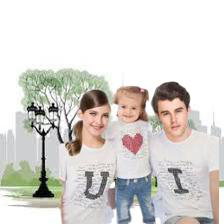

In [0]:
from PIL import Image
a = Image.open("/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg/batch_1/fg_bg_39602.jpg")
a

In [0]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image

In [0]:
class CustomDataset(Dataset):
  def __init__(self):
    self.data = []
    for i in range(1,40001):
      img = Image.open(f"/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg/batch_1/fg_bg_{str(i)}.jpg")
      npimg = np.asarray(img)
      self.data.append(npimg)
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data[idx]
    img = data     
    return data

In [0]:
dataset = CustomDataset()

In [0]:
npimg

array([[[ 0, 20, 24],
        [11, 39, 42],
        [ 6, 32, 33],
        ...,
        [19, 50, 44],
        [ 0, 40, 31],
        [ 0, 32, 21]],

       [[ 1, 31, 33],
        [15, 43, 46],
        [ 8, 34, 35],
        ...,
        [15, 46, 40],
        [ 0, 40, 31],
        [ 0, 35, 24]],

       [[ 0, 22, 24],
        [12, 40, 43],
        [26, 52, 53],
        ...,
        [12, 43, 37],
        [ 2, 42, 33],
        [ 0, 41, 30]],

       ...,

       [[ 9, 42, 87],
        [13, 46, 89],
        [20, 52, 93],
        ...,
        [84,  7, 13],
        [66,  0,  6],
        [89, 10, 29]],

       [[19, 43, 79],
        [22, 46, 82],
        [26, 48, 85],
        ...,
        [75, 19, 30],
        [38,  0, 13],
        [38,  0, 18]],

       [[28, 45, 75],
        [28, 45, 75],
        [28, 45, 75],
        ...,
        [45,  3, 15],
        [15,  0,  9],
        [22,  5, 24]]], dtype=uint8)